In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Run install

In [3]:
!pip install datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00


In [4]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.8 MB/s eta 0:00:00


In [5]:
from transformers import ViTForImageClassification, MobileNetV2Config, MobileNetV2ForImageClassification
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments
from datasets import load_dataset
import torch
import evaluate
import numpy as np

In [6]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")


Number of GPUs available: 1
GPU 0: Tesla T4


# Run data + models

In [7]:
processor = AutoImageProcessor.from_pretrained("merve/beans-vit-224")
model = AutoModelForImageClassification.from_pretrained("merve/beans-vit-224")

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [8]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [9]:
class CustomViTModel(ViTForImageClassification):
    def __init__(self, original_model,k):
        super(CustomViTModel, self).__init__(original_model.config)

        self.vit.embeddings = original_model.vit.embeddings
        self.vit.encoder.layer = nn.ModuleList(
            [original_model.vit.encoder.layer[i] for i in range(k)]
        )

        self.classifier = original_model.classifier

original_model = ViTForImageClassification.from_pretrained("merve/beans-vit-224")
student_model = CustomViTModel(original_model,6)

In [10]:
dataset = load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [10]:
from transformers import AutoImageProcessor
teacher_processor = AutoImageProcessor.from_pretrained("merve/beans-vit-224")
dataset = load_dataset("beans")

def process(examples):
    processed_inputs = teacher_processor(examples["image"])
    return processed_inputs

processed_datasets = dataset.map(process, batched=True)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [12]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImageDistilTrainer(Trainer):

    def __init__(self, teacher_model=None, student_model=None, temperature=1.0, lambda_param=0.5, *args, **kwargs):
        if student_model is None:
            raise ValueError("Student model must be provided for distillation")

        super().__init__(model=student_model, *args, **kwargs)

        self.teacher = teacher_model
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        self.temperature = temperature
        self.lambda_param = lambda_param

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.teacher.to(device)
        self.teacher.eval()


    def compute_loss(self, student, inputs, return_outputs=False):
        student_output = self.student(**inputs)

        with torch.no_grad():
          teacher_output = self.teacher(**inputs)

        soft_teacher = F.softmax(teacher_output.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        distillation_loss = self.loss_function(soft_student, soft_teacher) * (self.temperature ** 2)

        student_target_loss = student_output.loss

        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        return (loss, student_output) if return_outputs else loss

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

In [14]:
import evaluate
import numpy as np
from transformers import DefaultDataCollator

num_labels = len(processed_datasets["train"].features["labels"].names)
accuracy = evaluate.load("accuracy")
data_collator = DefaultDataCollator()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

In [15]:
import torch.nn.init as init

def reinitialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d):
            init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            if layer.bias is not None:
                init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.Linear):
            init.xavier_normal_(layer.weight)
            init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.LayerNorm):
            init.constant_(layer.weight, 1)
            init.constant_(layer.bias, 0)


# Raw Accuracies and parameters count

In [16]:
model_9 = CustomViTModel(original_model,9)
model_6 = CustomViTModel(original_model,6)
model_3 = CustomViTModel(original_model,3)

accuracy = evaluate.load("accuracy")

In [17]:
trainer = Trainer(
    model=model_9,
    compute_metrics=compute_metrics
)

acc = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
print(acc)

KeyboardInterrupt: ignored

In [ ]:
trainer = Trainer(
    model=model_6,
    compute_metrics=compute_metrics
)

# Evaluate the model
acc = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
print(acc)

In [ ]:
trainer = Trainer(
    model=model_3,
    compute_metrics=compute_metrics
)

# Evaluate the model
acc = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
print(acc)

In [ ]:
## Models size

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters_teacher = count_parameters(teacher_model)
num_parameters_9 = count_parameters(model_9)
num_parameters_6 = count_parameters(model_6)
num_parameters_3 = count_parameters(model_3)


print(num_parameters_teacher,num_parameters_9,num_parameters_6,num_parameters_3)


# HP tuning for Lambda and Temperature with WANDB

In [ ]:
# !pip install datasets wandb evaluate accelerate -qU
# !wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/text-classification/run_glue.py

In [ ]:
!pip install wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
# method
sweep_config = {
    'method': 'random'
}

parameters_dict = {
    'temperature':{
        'values':[1,3,5]
    },
    'lambda_param':{
        'values':[0.2,0.5,0.8]
    }
}

sweep_config['parameters'] = parameters_dict


In [ ]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config


    training_args = TrainingArguments(
        output_dir="distil_12_6",
        num_train_epochs=10,
        fp16=True,
        logging_dir=f"{repo_name}/logs",
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="wandb",
        run_name="vit-6",  # name of the W&B run (optional)
        logging_steps=1,  # how often to log to W&B
    )


    trainer = ImageDistilTrainer(
        student_model=student_model_6,
        teacher_model=teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        # tokenizer=teacher_extractor,
        compute_metrics=compute_metrics,
        temperature=config.temperature,
        lambda_param=config.lambda_param
)


    # start training loop
    trainer.train()


In [ ]:
sweep_id = wandb.sweep(sweep_config, project='distil_12_6_2')

Create sweep with ID: 3pdpsa1b
Sweep URL: https://wandb.ai/ed2994/distil_12_6_2/sweeps/3pdpsa1b


In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: ykl2qm2a with config:
wandb: 	lambda_param: 0.2
wandb: 	temperature: 3


wandb: WARNING Config item 'temperature' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.870000,0.747488,0.624060
2,0.702200,0.635416,0.691729
3,0.604100,0.566391,0.759398
4,0.576000,0.521619,0.796992
5,0.516600,0.547932,0.766917
6,0.475200,0.512757,0.796992
7,0.429200,0.477466,0.834586
8,0.379900,0.518418,0.819549
9,0.353400,0.450724,0.864662
10,0.319400,0.430144,0.887218


eval/accuracy,▁▃▅▆▅▆▇▆▇█
eval/loss,█▆▄▃▄▃▂▃▁▁
eval/runtime,▇▁▁▃▂▁▃▂▇█
eval/samples_per_second,▂██▆▇█▆▇▂▁
eval/steps_per_second,▂██▆▇█▆▇▂▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▅▄▄▃▂▂▁▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: kmw15baw with config:
wandb: 	lambda_param: 0.2
wandb: 	temperature: 1


wandb: WARNING Config item 'temperature' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.467500,0.488496,0.812030
2,0.405000,0.473922,0.834586
3,0.367000,0.571563,0.796992
4,0.336600,0.511140,0.834586
5,0.289100,0.416814,0.872180
6,0.271800,0.494869,0.864662
7,0.250000,0.490934,0.857143
8,0.240800,0.503930,0.842105
9,0.234600,0.496857,0.857143
10,0.233700,0.496782,0.857143


eval/accuracy,▂▄▁▄█▇▇▅▇▇
eval/loss,▄▄█▅▁▅▄▅▅▅
eval/runtime,▁▁▂▂▁▃█▂▃▁
eval/samples_per_second,██▇▇█▆▁▇▆█
eval/steps_per_second,▇█▇▇█▆▁▇▆█
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▅▄▃▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: r73pl6n5 with config:
wandb: 	lambda_param: 0.5
wandb: 	temperature: 3


wandb: WARNING Config item 'temperature' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.331200,0.406650,0.804511
2,0.332500,0.406486,0.812030
3,0.314000,0.404293,0.812030
4,0.299100,0.388421,0.827068
5,0.292800,0.378087,0.857143
6,0.289600,0.384538,0.849624
7,0.290000,0.390593,0.834586
8,0.286000,0.391564,0.827068
9,0.285200,0.376743,0.849624
10,0.285100,0.376830,0.857143


eval/accuracy,▁▂▂▄█▇▅▄▇█
eval/loss,██▇▄▁▃▄▄▁▁
eval/runtime,▁▃▂▁▂▁█▂▂▄
eval/samples_per_second,█▆▇█▇█▁▇▇▅
eval/steps_per_second,█▆▇█▆█▁▇▇▅
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,██▅▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: abhkehex with config:
wandb: 	lambda_param: 0.5
wandb: 	temperature: 5


wandb: WARNING Config item 'temperature' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.313200,0.394536,0.812030
2,0.315200,0.394027,0.812030
3,0.293600,0.415009,0.781955
4,0.290400,0.391100,0.827068
5,0.284900,0.395332,0.804511
6,0.281900,0.389378,0.827068
7,0.281200,0.407035,0.819549
8,0.279900,0.394209,0.834586
9,0.279600,0.394881,0.834586
10,0.279700,0.394756,0.834586


eval/accuracy,▅▅▁▇▄▇▆███
eval/loss,▂▂█▁▃▁▆▂▃▂
eval/runtime,▁▂▄▄█▁▁▂▇▂
eval/samples_per_second,█▇▅▅▁█▇▇▂▇
eval/steps_per_second,█▇▅▅▁██▇▂▇
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,██▄▃▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: t7c39p4h with config:
wandb: 	lambda_param: 0.5
wandb: 	temperature: 5


wandb: WARNING Config item 'temperature' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.306900,0.395846,0.812030
2,0.298700,0.396938,0.819549
3,0.290200,0.409377,0.812030
4,0.292400,0.400776,0.812030
5,0.280400,0.391180,0.827068
6,0.278200,0.389729,0.834586
7,0.278200,0.396452,0.819549
8,0.278100,0.395892,0.819549
9,0.278000,0.395996,0.819549
10,0.278000,0.395818,0.819549


eval/accuracy,▁▃▁▁▆█▃▃▃▃
eval/loss,▃▄█▅▂▁▃▃▃▃
eval/runtime,▁▁▂▂█▁▂▂▆▂
eval/samples_per_second,██▇▆▁█▇▇▃▇
eval/steps_per_second,██▇▆▁█▇▇▃▇
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▄▄▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


 Best temperature 3, lambda 0.2

In [ ]:
metrics = trainer.evaluate()
print("Test set accuracy:", metrics['eval_accuracy'])

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'temperature' was locked by 'sweep' (ignored update).


Test set accuracy: 0.8345864661654135


# Train optimal WB HP

In [ ]:
student_model_6 = CustomViTModel(teacher_model,6)
reinitialize_weights(student_model_6)

training_args = TrainingArguments(
        output_dir="distil_12_6_HP",
        num_train_epochs=15,
        fp16=True,
        logging_dir=f"{repo_name}/logs",
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
    )


trainer = ImageDistilTrainer(
        student_model=student_model_6,
        teacher_model=teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        # tokenizer=teacher_extractor,
        compute_metrics=compute_metrics,
        temperature=3,
        lambda_param=0.2
)

trainer.train()
trainer.evaluate(processed_datasets["test"])

wandb: WARNING Config item 'temperature' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.971600,0.696432,0.646617
2,0.681000,0.678213,0.699248
3,0.615300,0.578690,0.751880
4,0.566100,0.520638,0.789474
5,0.515000,0.491532,0.827068
6,0.475800,0.546211,0.774436
7,0.444200,0.504976,0.789474
8,0.400800,0.477356,0.857143
9,0.371500,0.447434,0.872180
10,0.327700,0.494504,0.864662


{'eval_loss': 0.5208900570869446,
 'eval_accuracy': 0.8125,
 'eval_runtime': 15.4155,
 'eval_samples_per_second': 8.303,
 'eval_steps_per_second': 1.038,
 'epoch': 15.0}

In [ ]:
from datasets import load_metric

teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

teacher_model.eval()

training_args = TrainingArguments("test_trainer")

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

a = trainer.evaluate(processed_datasets["test"])

wandb: WARNING Config item 'temperature' was locked by 'sweep' (ignored update).


# Loop for the 4 training

In [17]:
def train_and_compare( modelList,temperature,lambda_param,epochs):
  accuracies = []
  direct_accuracy = 0
  ###### train and evaluate straighforward distillation from model_0 to model-1 #####

  training_args = TrainingArguments(
        logging_dir=f"{repo_name}/logs",
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=epochs,
        output_dir = 'loop_test',
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy")

  # trainer = ImageDistilTrainer(
  #         student_model=modelList[-1],
  #         teacher_model=modelList[0],
  #         args=training_args,
  #         train_dataset=processed_datasets["train"],
  #         eval_dataset=processed_datasets["validation"],
  #         data_collator=data_collator,
  #         compute_metrics=compute_metrics,
  #         temperature=temperature,
  #         lambda_param=lambda_param)

  # trainer.train()
  # direct_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']

  ################################## multistep distillation ###############################
  for k in range(1,len(modelList)):
      print('k = {}'.format(k))
      intermediary_model = modelList[k]
      intermediary_teacher = modelList[k-1]

      trainer = ImageDistilTrainer(

              student_model= intermediary_model,
              teacher_model= intermediary_teacher,
              args=training_args,
              train_dataset=processed_datasets["train"],
              eval_dataset=processed_datasets["validation"],
              data_collator=data_collator,
              compute_metrics=compute_metrics,
              temperature=temperature,
              lambda_param=lambda_param)

      trainer.train()
      interm_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
      accuracies.append(interm_accuracy)

  return accuracies



In [18]:
teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)

modelList = [teacher_model,student_model_9,student_model_6,student_model_3]

In [19]:
repo_name = 'test'
a,b = train_and_compare( modelList,temperature=3,lambda_param=0.2,epochs=10)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.535600,0.321018,0.902256
2,0.261000,0.196841,0.977444
3,0.184400,0.212890,0.969925
4,0.162200,0.196831,0.984962
5,0.145900,0.169815,1.000000
6,0.142000,0.167268,1.000000
7,0.139800,0.167961,1.000000
8,0.139200,0.169644,1.000000
9,0.139100,0.168643,1.000000
10,0.138700,0.168512,1.000000


4
k = 1


Epoch,Training Loss,Validation Loss,Accuracy
1,0.176700,0.169960,1.000000
2,0.153700,0.161905,1.000000
3,0.154300,0.167662,1.000000
4,0.159200,0.169583,1.000000
5,0.165700,0.189721,0.992481
6,0.169400,0.180118,1.000000
7,0.176100,0.189264,1.000000
8,0.186200,0.202362,1.000000
9,0.199400,0.212673,1.000000
10,0.205500,0.214080,1.000000


k = 2


Epoch,Training Loss,Validation Loss,Accuracy
1,0.054500,0.068581,1.000000
2,0.047100,0.104768,0.969925
3,0.049500,0.064687,0.992481
4,0.045700,0.062632,0.992481
5,0.050100,0.062753,0.984962
6,0.045600,0.060497,0.992481
7,0.045700,0.061560,0.992481
8,0.045700,0.062310,0.984962
9,0.045800,0.061701,0.992481
10,0.045800,0.061934,0.992481


k = 3


Epoch,Training Loss,Validation Loss,Accuracy
1,0.022900,0.062199,0.984962
2,0.020800,0.052403,0.977444
3,0.018500,0.060315,0.977444
4,0.019600,0.061649,0.984962
5,0.019100,0.056760,0.984962
6,0.018700,0.065387,0.977444
7,0.018300,0.066158,0.984962
8,0.018400,0.064050,0.984962
9,0.018500,0.069012,0.984962
10,0.018500,0.068440,0.984962


In [20]:
print(a)
print(b)

[0.9375, 0.953125, 0.9453125]
0.9375


In [26]:
teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)

reinitialize_weights(student_model_9)
reinitialize_weights(student_model_6)
reinitialize_weights(student_model_3)


modelList = [teacher_model,student_model_9,student_model_6,student_model_3]

In [29]:
repo_name = 'test'
a_,b_ = train_and_compare( modelList,temperature=3,lambda_param=0.2,epochs=10)

Epoch,Training Loss,Validation Loss,Accuracy
1,1.103400,0.931325,0.548872
2,0.735700,0.694283,0.646617
3,0.591800,0.588594,0.766917
4,0.536600,0.547485,0.796992
5,0.498500,0.528247,0.796992
6,0.432100,0.515385,0.796992
7,0.388800,0.527134,0.812030
8,0.340400,0.561742,0.796992
9,0.314000,0.501519,0.819549
10,0.291300,0.506538,0.804511


4
k = 1


Epoch,Training Loss,Validation Loss,Accuracy
1,0.563300,0.822722,0.669173
2,0.422100,0.608489,0.706767
3,0.347300,0.516653,0.819549
4,0.298200,0.540400,0.796992
5,0.274200,0.503860,0.819549
6,0.257900,0.539757,0.804511
7,0.244400,0.535430,0.774436
8,0.239700,0.520291,0.804511
9,0.237600,0.524375,0.796992
10,0.236500,0.525570,0.781955


k = 2


Epoch,Training Loss,Validation Loss,Accuracy
1,0.216000,0.481181,0.819549
2,0.172400,0.455099,0.804511
3,0.115400,0.547471,0.744361
4,0.081300,0.491626,0.774436
5,0.066600,0.494841,0.804511
6,0.060800,0.491527,0.796992
7,0.059200,0.496474,0.796992
8,0.058500,0.496458,0.789474
9,0.058300,0.497067,0.796992
10,0.058200,0.496248,0.804511


k = 3


Epoch,Training Loss,Validation Loss,Accuracy
1,0.196100,0.475301,0.781955
2,0.142900,0.422055,0.804511
3,0.116700,0.503339,0.781955
4,0.097000,0.499870,0.789474
5,0.086900,0.497365,0.774436
6,0.081100,0.443124,0.819549
7,0.079400,0.441776,0.819549
8,0.079100,0.442657,0.812030
9,0.079100,0.439020,0.827068
10,0.078600,0.439885,0.827068


In [30]:
print(a_)
print(b_)

[0.7890625, 0.8125, 0.7890625]
0.8203125


# Multi agent implementation

In [18]:
class BI_ImageDistilTrainer(Trainer):

    def __init__(self, teacher_model_1=None, teacher_model_2=None, student_model=None, temperature=1.0, lambda_param=0.5, alpha=0.5, *args, **kwargs):

        super().__init__(model=student_model, *args, **kwargs)

        self.teacher_1 = teacher_model_1
        self.teacher_2 = teacher_model_2
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        self.temperature = temperature
        self.lambda_param = lambda_param
        self.alpha = alpha  # New parameter to balance the contribution of each teacher model

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.teacher_1.to(device)
        self.teacher_1.eval()
        self.teacher_2.to(device)
        self.teacher_2.eval()

    def compute_loss(self, student, inputs, return_outputs=False):
        student_output = self.student(**inputs)

        with torch.no_grad():
            teacher_output_1 = self.teacher_1(**inputs)
            teacher_output_2 = self.teacher_2(**inputs)

        soft_teacher_1 = F.softmax(teacher_output_1.logits / self.temperature, dim=-1)
        soft_teacher_2 = F.softmax(teacher_output_2.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        distillation_loss_1 = self.loss_function(soft_student, soft_teacher_1) * (self.temperature ** 2)
        distillation_loss_2 = self.loss_function(soft_student, soft_teacher_2) * (self.temperature ** 2)

        distillation_loss = self.alpha * distillation_loss_1 + (1 - self.alpha) * distillation_loss_2

        student_target_loss = student_output.loss

        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        return (loss, student_output) if return_outputs else loss


In [19]:
def bi_train_and_compare( modelList,temperature,lambda_param,alpha,epochs):
  accuracies = []
  direct_accuracy = 0
  repo_name = 'test'

  ###### train and evaluate straighforward distillation from model_0 to model-1 #####

  training_args = TrainingArguments(
        logging_dir=f"{repo_name}/logs",
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=epochs,
        output_dir = 'loop_test',
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy")

  # trainer = ImageDistilTrainer(
  #         student_model=modelList[-1],
  #         teacher_model=modelList[0],
  #         args=training_args,
  #         train_dataset=processed_datasets["train"],
  #         eval_dataset=processed_datasets["validation"],
  #         data_collator=data_collator,
  #         compute_metrics=compute_metrics,
  #         temperature=temperature,
  #         lambda_param=lambda_param)

  # trainer.train()
  # direct_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']

  ################################## multistep distillation ###############################
  print(len(modelList))
  for k in range(1,len(modelList)):
      if k == 1 :

        ## NO multiagent

        print('k = {}'.format(k))
        intermediary_model = modelList[k]
        intermediary_teacher = modelList[k-1]

        trainer = ImageDistilTrainer(

                student_model= intermediary_model,
                teacher_model= intermediary_teacher,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param)

        trainer.train()
        interm_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
        accuracies.append(interm_accuracy)
      else :

        ## At least two bigger models so multi agent distillation

        print('k = {}'.format(k))
        intermediary_teacher_1 = modelList[k-1]
        intermediary_teacher_2 = modelList[k-2]
        intermediary_student = modelList[k]

        print()

        trainer = BI_ImageDistilTrainer(

                student_model = intermediary_student,
                teacher_model_1 = intermediary_teacher_1,
                teacher_model_2 = intermediary_teacher_2,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param,
                alpha = alpha)

        trainer.train()
        interm_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
        accuracies.append(interm_accuracy)

  return accuracies



# With original weights

In [61]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)

# reinitialize_weights(student_model_9)
# reinitialize_weights(student_model_6)
# reinitialize_weights(student_model_3)

# student_model_6 = reinitialize_weights(student_model_6)
# student_model_3 = reinitialize_weights(student_model_3)

modelList = [teacher_model,student_model_9,student_model_6,student_model_3]

In [62]:
a_bi, b_bi = bi_train_and_compare(modelList,temperature=3,lambda_param=0.2,alpha=0.5,epochs=10)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.535600,0.320940,0.902256
2,0.261000,0.196840,0.977444
3,0.184400,0.212995,0.969925
4,0.162200,0.196697,0.984962
5,0.145900,0.169842,1.000000
6,0.142000,0.167309,1.000000
7,0.139800,0.167982,1.000000
8,0.139200,0.169648,1.000000
9,0.139100,0.168650,1.000000
10,0.138700,0.168553,1.000000


4
k = 1


Epoch,Training Loss,Validation Loss,Accuracy
1,0.176000,0.167085,1.000000
2,0.150000,0.158656,1.000000
3,0.153100,0.190059,0.977444
4,0.154800,0.172755,0.969925
5,0.148100,0.155206,0.992481
6,0.148100,0.154679,1.000000
7,0.148700,0.160042,0.984962
8,0.148200,0.156816,0.992481
9,0.148500,0.156420,0.992481
10,0.149100,0.156431,0.992481


k = 2



Epoch,Training Loss,Validation Loss,Accuracy
1,0.127900,0.137564,0.992481
2,0.126000,0.143985,0.992481
3,0.125000,0.188591,0.947368
4,0.127100,0.135802,0.992481
5,0.124200,0.134327,0.992481
6,0.125000,0.135838,0.992481
7,0.126100,0.136944,0.992481
8,0.126400,0.137089,0.992481
9,0.126200,0.136915,0.992481
10,0.126600,0.137056,0.992481


k = 3



Epoch,Training Loss,Validation Loss,Accuracy
1,0.052100,0.079956,0.992481
2,0.048200,0.078029,0.992481
3,0.043400,0.077707,1.000000
4,0.043400,0.075608,1.000000
5,0.043100,0.075220,1.000000
6,0.043100,0.074079,1.000000
7,0.043000,0.073974,1.000000
8,0.043000,0.073038,1.000000
9,0.043000,0.073630,1.000000
10,0.043000,0.073510,1.000000


In [63]:
print(a_bi)
print(b_bi)

[0.9375, 0.9375, 0.9453125]
0.9375


# With reinitialized weights

In [64]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)

reinitialize_weights(student_model_9)
reinitialize_weights(student_model_6)
reinitialize_weights(student_model_3)

# student_model_6 = reinitialize_weights(student_model_6)
# student_model_3 = reinitialize_weights(student_model_3)

modelList = [teacher_model,student_model_9,student_model_6,student_model_3]

In [65]:
a_bi_re , b_bi_re = bi_train_and_compare(modelList,temperature=3,lambda_param=0.2,alpha=0.5,epochs=10)

Epoch,Training Loss,Validation Loss,Accuracy
1,1.100900,0.907933,0.496241
2,0.709700,0.668662,0.691729
3,0.583300,0.679516,0.699248
4,0.545300,0.545727,0.812030
5,0.503000,0.605161,0.714286
6,0.437600,0.557773,0.789474
7,0.397300,0.541580,0.789474
8,0.354600,0.585835,0.789474
9,0.325900,0.523673,0.812030
10,0.301200,0.523311,0.804511


4
k = 1


Epoch,Training Loss,Validation Loss,Accuracy
1,0.689200,0.682221,0.646617
2,0.508500,0.582248,0.766917
3,0.442500,0.706778,0.646617
4,0.400100,0.514782,0.819549
5,0.340600,0.558715,0.781955
6,0.289700,0.556039,0.796992
7,0.266200,0.561686,0.781955
8,0.249200,0.546541,0.766917
9,0.241400,0.547482,0.781955
10,0.238500,0.545314,0.781955


k = 2



Epoch,Training Loss,Validation Loss,Accuracy
1,0.357200,0.528620,0.766917
2,0.306900,0.544771,0.766917
3,0.252900,0.509592,0.804511
4,0.211400,0.575763,0.781955
5,0.195800,0.536470,0.774436
6,0.181700,0.561794,0.789474
7,0.174700,0.555380,0.789474
8,0.172700,0.557843,0.781955
9,0.171800,0.551564,0.789474
10,0.171600,0.551954,0.789474


k = 3



Epoch,Training Loss,Validation Loss,Accuracy
1,0.203100,0.560298,0.744361
2,0.191200,0.569617,0.759398
3,0.180500,0.501621,0.774436
4,0.149200,0.524291,0.789474
5,0.134500,0.450141,0.819549
6,0.124900,0.531877,0.804511
7,0.123300,0.500673,0.789474
8,0.121200,0.508704,0.781955
9,0.120900,0.513116,0.781955
10,0.120500,0.513295,0.781955


In [67]:
print(a_bi_re,b_bi_re)

[0.8203125, 0.8203125, 0.828125] 0.8046875


# Straighforward distillation

In [68]:
repo_name = "test"

training_args = TrainingArguments(
      logging_dir=f"{repo_name}/logs",
      logging_strategy="epoch",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      num_train_epochs=10,
      output_dir = 'loop_test',
      fp16=True,
      load_best_model_at_end=True,
      metric_for_best_model="accuracy")

num_labels = len(processed_datasets["train"].features["labels"].names)

teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)

reinitialize_weights(student_model_9)
reinitialize_weights(student_model_6)
reinitialize_weights(student_model_3)

trainer1 = ImageDistilTrainer(
        student_model= student_model_9,
        teacher_model= teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=3,
        lambda_param=0.2)

trainer1.train()
acc1 = trainer1.evaluate(processed_datasets["test"])['eval_accuracy']

trainer2 = ImageDistilTrainer(
        student_model= student_model_6,
        teacher_model= teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=3,
        lambda_param=0.2)

trainer2.train()
acc2 = trainer2.evaluate(processed_datasets["test"])['eval_accuracy']

trainer3 = ImageDistilTrainer(
        student_model= student_model_3,
        teacher_model= teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=3,
        lambda_param=0.2)

trainer3.train()
acc3 = trainer3.evaluate(processed_datasets["test"])['eval_accuracy']

acc = [acc1,acc2,acc3]
print('straightforward accuracies : {}'.format(acc))

Epoch,Training Loss,Validation Loss,Accuracy
1,1.200100,0.893634,0.526316
2,0.701300,0.743838,0.639098
3,0.574200,0.646450,0.676692
4,0.505400,0.510837,0.796992
5,0.433300,0.521638,0.789474
6,0.372200,0.498483,0.781955
7,0.327900,0.559807,0.781955
8,0.286100,0.582634,0.789474
9,0.261600,0.511818,0.759398
10,0.246300,0.506160,0.812030


Epoch,Training Loss,Validation Loss,Accuracy
1,0.368100,0.546410,0.827068
2,0.351000,0.591642,0.796992
3,0.298300,0.542895,0.834586
4,0.274800,0.506354,0.819549
5,0.252700,0.561967,0.789474
6,0.247200,0.556697,0.789474
7,0.245300,0.557220,0.796992
8,0.244700,0.549676,0.781955
9,0.244300,0.550399,0.774436
10,0.244100,0.550854,0.789474


Epoch,Training Loss,Validation Loss,Accuracy
1,0.463800,0.561812,0.812030
2,0.319200,0.551053,0.804511
3,0.291200,0.569426,0.774436
4,0.272300,0.538178,0.827068
5,0.265600,0.547898,0.789474
6,0.262000,0.546229,0.812030
7,0.258300,0.515535,0.819549
8,0.257300,0.520607,0.812030
9,0.256900,0.527842,0.804511
10,0.256600,0.527874,0.804511


straightforward accuracies : [0.890625, 0.8125, 0.84375]


# Multi Agent KD - 3 models to the smaller


In [20]:
class tri_ImageDistilTrainer(Trainer):

    def __init__(self, teacher_model_1=None, teacher_model_2=None,teacher_model_3=None, student_model=None, temperature=1.0, lambda_param=0.5, betas=[1/3,1/3,1/3], *args, **kwargs):

        super().__init__(model=student_model, *args, **kwargs)

        self.teacher_1 = teacher_model_1
        self.teacher_2 = teacher_model_2
        self.teacher_3 = teacher_model_2
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        self.temperature = temperature
        self.lambda_param = lambda_param
        self.betas = betas  # New parameter to balance the contribution of each teacher model

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.teacher_1.to(device)
        self.teacher_1.eval()
        self.teacher_2.to(device)
        self.teacher_2.eval()
        self.teacher_3.to(device)
        self.teacher_3.eval()

    def compute_loss(self, student, inputs, return_outputs=False):
        student_output = self.student(**inputs)

        with torch.no_grad():
            teacher_output_1 = self.teacher_1(**inputs)
            teacher_output_2 = self.teacher_2(**inputs)
            teacher_output_3 = self.teacher_3(**inputs)

        soft_teacher_1 = F.softmax(teacher_output_1.logits / self.temperature, dim=-1)
        soft_teacher_2 = F.softmax(teacher_output_2.logits / self.temperature, dim=-1)
        soft_teacher_3 = F.softmax(teacher_output_3.logits / self.temperature, dim=-1)

        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        distillation_loss_1 = self.loss_function(soft_student, soft_teacher_1) * (self.temperature ** 2)
        distillation_loss_2 = self.loss_function(soft_student, soft_teacher_2) * (self.temperature ** 2)
        distillation_loss_3 = self.loss_function(soft_student, soft_teacher_3) * (self.temperature ** 2)


        distillation_loss = self.betas[0] * distillation_loss_1 + self.betas[1] * distillation_loss_2 + self.betas[2]*distillation_loss_3

        student_target_loss = student_output.loss

        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        return (loss, student_output) if return_outputs else loss


In [21]:
def tri_train_and_compare( modelList,temperature,lambda_param,alpha,betas,epochs):
  accuracies = []
  direct_accuracy = 0
  repo_name = 'test'

  ###### train and evaluate straighforward distillation from model_0 to model-1 #####

  training_args = TrainingArguments(
        logging_dir=f"{repo_name}/logs",
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=epochs,
        output_dir = 'loop_test',
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy")

  # trainer = ImageDistilTrainer(
  #         student_model=modelList[-1],
  #         teacher_model=modelList[0],
  #         args=training_args,
  #         train_dataset=processed_datasets["train"],
  #         eval_dataset=processed_datasets["validation"],
  #         data_collator=data_collator,
  #         compute_metrics=compute_metrics,
  #         temperature=temperature,
  #         lambda_param=lambda_param)

  # trainer.train()
  # direct_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']

  ################################## multistep distillation ###############################
  print(len(modelList))
  for k in range(1,len(modelList)):
      if k == 1 :

        ## NO multiagent

        print('k = {}'.format(k))
        intermediary_model = modelList[k]
        intermediary_teacher = modelList[k-1]

        trainer = ImageDistilTrainer(

                student_model= intermediary_model,
                teacher_model= intermediary_teacher,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param)

        trainer.train()
        interm_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
        accuracies.append(interm_accuracy)

      if k == 2 :

        ## At least two bigger models so multi agent distillation

        print('k = {}'.format(k))
        intermediary_teacher_1 = modelList[k-1]
        intermediary_teacher_2 = modelList[k-2]
        intermediary_student = modelList[k]

        print()

        trainer = BI_ImageDistilTrainer(

                student_model = intermediary_student,
                teacher_model_1 = intermediary_teacher_1,
                teacher_model_2 = intermediary_teacher_2,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param,
                alpha = alpha)

        trainer.train()
        interm_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
        accuracies.append(interm_accuracy)

      if k == 3 :

        ## At least two bigger models so multi agent distillation

        print('k = {}'.format(k))
        intermediary_teacher_1 = modelList[k-1]
        intermediary_teacher_2 = modelList[k-2]
        intermediary_teacher_3 = modelList[k-3]

        intermediary_student = modelList[k]

        trainer = tri_ImageDistilTrainer(

                student_model = intermediary_student,
                teacher_model_1 = intermediary_teacher_1,
                teacher_model_2 = intermediary_teacher_2,
                teacher_model_3 = intermediary_teacher_3,

                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param,
                betas = betas)

        trainer.train()
        interm_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
        accuracies.append(interm_accuracy)


  return accuracies



In [ ]:
student_model_3 = CustomViTModel(teacher_model,3)

tri_trainer = tri_ImageDistilTrainer(
        student_model = student_model_3,
        teacher_model_1 = student_model_6,
        teacher_model_2 = student_model_9,
        teacher_model_3 = teacher_model
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=temperature,
        lambda_param=lambda_param,
        alpha = alpha)

tri_trainer.train()
multi_agent_acc = tri_trainer.evaluate(processed_datasets["test"])['eval_accuracy']

print(multi_agent_acc)

# The ultimate loop

In [17]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [ ]:
### define args,models and reinitialize the weights

In [18]:
repo_name = "test"

training_args = TrainingArguments(
      logging_dir=f"{repo_name}/logs",
      logging_strategy="epoch",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      num_train_epochs=10,
      output_dir = 'loop_test',
      fp16=True,
      load_best_model_at_end=True,
      metric_for_best_model="accuracy")

num_labels = len(processed_datasets["train"].features["labels"].names)

teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)

reinitialize_weights(student_model_9)
reinitialize_weights(student_model_6)
reinitialize_weights(student_model_3)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters_teacher = count_parameters(teacher_model)
num_parameters_student_9 = count_parameters(student_model_9)
num_parameters_student_6 = count_parameters(student_model_6)
num_parameters_student_3 = count_parameters(student_model_3)



print(f"Number of parameters in the original model: {num_parameters_teacher}")
print(f"Number of parameters in the 9 VIT model: {num_parameters_student_9}")
print(f"Number of parameters in the 9 VIT model: {num_parameters_student_6}")
print(f"Number of parameters in the 9 VIT model: {num_parameters_student_3}")


Number of parameters in the original model: 85800963
Number of parameters in the 9 VIT model: 64537347
Number of parameters in the 9 VIT model: 43273731
Number of parameters in the 9 VIT model: 22010115


# Straighforward KD

In [24]:
straight_9 = copy_model(student_model_9)
straight_6 = copy_model(student_model_6)
straight_3 = copy_model(student_model_3)


trainer1 = ImageDistilTrainer(
        student_model= straight_9,
        teacher_model= teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=3,
        lambda_param=0.4)

trainer1.train()
acc1 = trainer1.evaluate(processed_datasets["test"])['eval_accuracy']

trainer2 = ImageDistilTrainer(
        student_model= straight_6,
        teacher_model= teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=3,
        lambda_param=0.4)

trainer2.train()
acc2 = trainer2.evaluate(processed_datasets["test"])['eval_accuracy']

trainer3 = ImageDistilTrainer(
        student_model= straight_3,
        teacher_model= teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=3,
        lambda_param=0.4)

trainer3.train()
acc3 = trainer3.evaluate(processed_datasets["test"])['eval_accuracy']

acc = [acc1,acc2,acc3]
print('straightforward accuracies : {}'.format(acc))
### into txt


file_path = '/straight.txt'

with open(file_path, 'w') as file:
    file.write(str(acc))

Epoch,Training Loss,Validation Loss,Accuracy
1,1.029500,0.666612,0.518797
2,0.617700,0.686155,0.481203
3,0.523900,0.507373,0.721805
4,0.488600,0.514378,0.759398
5,0.465100,0.471497,0.827068
6,0.423100,0.477268,0.789474
7,0.396100,0.479496,0.804511
8,0.370100,0.445877,0.864662
9,0.354100,0.451143,0.827068
10,0.340700,0.446474,0.842105


Epoch,Training Loss,Validation Loss,Accuracy
1,0.935100,0.732790,0.473684
2,0.604500,0.599284,0.639098
3,0.525200,0.508416,0.751880
4,0.491900,0.495951,0.789474
5,0.458100,0.478049,0.804511
6,0.424600,0.488423,0.796992
7,0.399800,0.489376,0.781955
8,0.374500,0.465178,0.796992
9,0.355000,0.457813,0.819549
10,0.342900,0.455798,0.827068


Epoch,Training Loss,Validation Loss,Accuracy
1,0.834000,0.692522,0.503759
2,0.604100,0.754540,0.398496
3,0.526700,0.535068,0.729323
4,0.498700,0.493669,0.796992
5,0.469800,0.476882,0.804511
6,0.455400,0.488866,0.759398
7,0.424500,0.465573,0.804511
8,0.403200,0.467042,0.789474
9,0.386600,0.446760,0.842105
10,0.372800,0.446342,0.872180


straightforward accuracies : [0.84375, 0.8359375, 0.828125]


In [ ]:
### Succesive KD

In [25]:
successive_9 = copy_model(student_model_9)
successive_6 = copy_model(student_model_6)
successive_3 = copy_model(student_model_3)

In [26]:
modelList = [teacher_model,successive_9,successive_6,successive_3]
a = train_and_compare( modelList,temperature=3,lambda_param=0.4,epochs=10)
print('Succesive KD: {}'.format(a))

file_path = '/successive.txt'

with open(file_path, 'w') as file:
    file.write(str(a))

k = 1


Epoch,Training Loss,Validation Loss,Accuracy
1,1.029500,0.666612,0.518797
2,0.617700,0.686155,0.481203
3,0.523900,0.507373,0.721805
4,0.488600,0.514378,0.759398
5,0.465100,0.471497,0.827068
6,0.423100,0.477268,0.789474
7,0.396100,0.479496,0.804511
8,0.370100,0.445877,0.864662
9,0.354100,0.451143,0.827068
10,0.340700,0.446474,0.842105


k = 2


Epoch,Training Loss,Validation Loss,Accuracy
1,0.860100,0.667084,0.616541
2,0.604300,0.562672,0.669173
3,0.449100,0.468181,0.744361
4,0.398200,0.412355,0.789474
5,0.335400,0.381914,0.789474
6,0.272700,0.355435,0.804511
7,0.232100,0.395181,0.781955
8,0.194700,0.362745,0.812030
9,0.166900,0.348347,0.804511
10,0.156700,0.346664,0.834586


k = 3


Epoch,Training Loss,Validation Loss,Accuracy
1,1.210600,0.953611,0.511278
2,0.681100,0.630904,0.661654
3,0.489800,0.468801,0.751880
4,0.422700,0.444305,0.781955
5,0.339200,0.363722,0.819549
6,0.270400,0.375606,0.842105
7,0.223600,0.415673,0.819549
8,0.174000,0.352809,0.827068
9,0.135700,0.350389,0.834586
10,0.116100,0.338553,0.834586


Succesive KD: [0.84375, 0.859375, 0.875]


# Multi Agent with succesive KD


In [22]:

multi_9 = copy_model(student_model_9)
multi_6 = copy_model(student_model_6)
multi_3 = copy_model(student_model_3)

modelList = [teacher_model,multi_9,multi_6,multi_3]
a = tri_train_and_compare( modelList,temperature=3,lambda_param=0.4,alpha=0.5,betas=[1/3,1/3,1/3],epochs=10)
print('Succesive Multi Agent KD: {}'.format(a))


file_path = '/multi.txt'

with open(file_path, 'w') as file:
    file.write(str(a))

NameError: ignored

# Plot and Conclusion

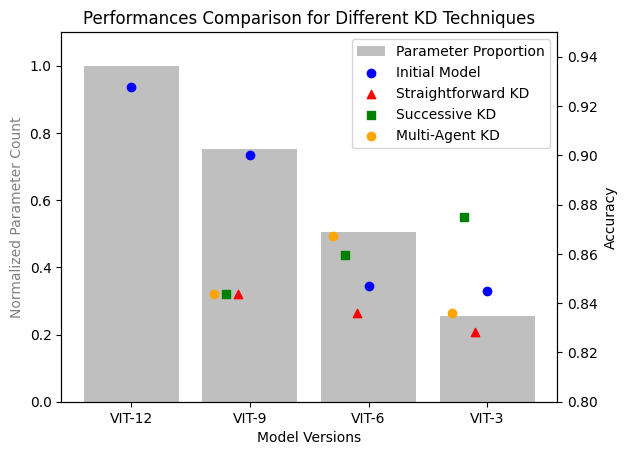

In [38]:
import matplotlib.pyplot as plt
import numpy as np

model_versions = ['VIT-12', 'VIT-9', 'VIT-6', 'VIT-3']
parameters = [85800963, 64537347, 43273731, 22010115] # Number of parameters for each version
raw_accuracies = [0.9375, 0.734375, 0.34375, 0.328125] # Raw accuracies of the models

normalized_parameters = [x / max(parameters) for x in parameters]

kd_accuracies = {
    'Straightforward KD': [0.84375, 0.8359375, 0.828125],
    'Successive KD': [0.84375, 0.859375, 0.875],
    'Multi-Agent KD': [0.84375, 0.8671875, 0.8359375]
}

fig, ax1 = plt.subplots()

bars = ax1.bar(model_versions, normalized_parameters, color='grey', label='Parameter Proportion', alpha=0.5)

initial_model_scatter = ax1.scatter(model_versions, raw_accuracies, color='blue', label='Initial Model')

offset = 0.1
colors = ['red', 'green', 'orange']
shapes = ['^', 's', 'o']
kd_scatters = []

ax2 = ax1.twinx()

for kd_method, (color, shape) in zip(kd_accuracies, zip(colors, shapes)):
    x_positions = np.array(range(len(model_versions))) - offset
    sc = ax2.scatter(x_positions[1:], kd_accuracies[kd_method], color=color, marker=shape, label=kd_method)
    kd_scatters.append(sc)
    offset += 0.1

ax1.set_xlabel('Model Versions')
ax1.set_ylabel('Normalized Parameter Count', color='grey')
ax2.set_ylabel('Accuracy', color='black')
ax1.set_ylim(0, 1.1)
ax2.set_ylim(0.8, 0.95)

handles, labels = [], []
handles.append(bars)
labels.append('Parameter Proportion')
handles.append(initial_model_scatter)
labels.append('Initial Model')
for sc in kd_scatters:
    handles.append(sc)
    labels.append(sc.get_label())

ax2.legend(handles, labels, loc='upper right')

plt.title('Performances Comparison for Different KD Techniques')
plt.show()


In [40]:
import pandas as pd
from IPython.display import display

models = ['VIT-12', 'VIT-9', 'VIT-6', 'VIT-3']
parameters = [85800963, 64537347, 43273731, 22010115]
raw_accuracies = [0.9375, 0.734375, 0.34375, 0.328125]
kd_accuracies = {
    'Straightforward KD': [None, 0.84375, 0.8359375, 0.828125],
    'Successive KD': [None, 0.84375, 0.859375, 0.875],
    'Multi-Agent KD': [None, 0.84375, 0.8671875, 0.8359375]
}

df = pd.DataFrame({
    'Model': models,
    'Parameters': parameters,
    'Raw Accuracy': raw_accuracies,
    'Straightforward KD': kd_accuracies['Straightforward KD'],
    'Successive KD': kd_accuracies['Successive KD'],
    'Multi-Agent KD': kd_accuracies['Multi-Agent KD']
})

display(df)


,Model,Parameters,Raw Accuracy,Straightforward KD,Successive KD,Multi-Agent KD
0,VIT-12,85800963,0.937500,NaN,NaN,NaN
1,VIT-9,64537347,0.734375,0.843750,0.843750,0.843750
2,VIT-6,43273731,0.343750,0.835938,0.859375,0.867188
3,VIT-3,22010115,0.328125,0.828125,0.875000,0.835938
